Using cache found in C:\Users\annik/.cache\torch\hub\pytorch_vision_v0.13.1
C:\Users\annik/.cache\torch\hub\pytorch_vision_v0.13.1\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\annik/.cache\torch\hub\pytorch_vision_v0.13.1\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\annik/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\annik/.cache\torch\hub\pytorch_vision_v0.13.1\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be remove

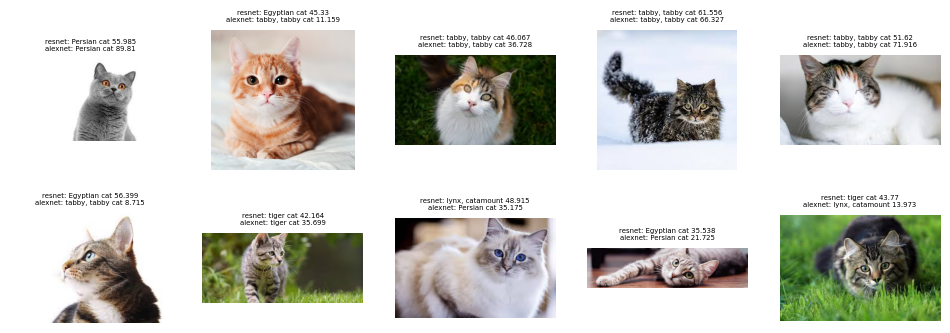

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  5 12:14:56 2023

@author: annik
"""

# Aufgabe 1

import torch
from torch import hub

resnet = hub.load('pytorch/vision:v0.13.1', 'resnet18',  pretrained=True)
alexnet = hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
resnet.eval()
alexnet.eval()


from torchvision import transforms

preprocess = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

from PIL import Image

with open('imagenet_classes.txt') as f: labels = [line.strip() for line in f.readlines()]

img = Image.open("Cat.jpg")
img1 = Image.open("Cat2.jpg")
img2 = Image.open("Cat3.jpg")
img3 = Image.open("Cat4.jpg")
img4 = Image.open("Cat5.jpg")
img5 = Image.open("Cat6.jpg")
img6 = Image.open("Cat7.jpg")
img7 = Image.open("Cat8.jpg")
img8 = Image.open("Cat9.jpg")
img9 = Image.open("Cat10.jpg")

image_datas = [img,img1,img2,img3,img4,img5,img6,img7,img9,img8]

import matplotlib.pyplot as plt
f, axarr = plt.subplots(2,5,figsize=(12, 4))
u = 0
j = 0
for i in range(0,10):
    img_t = preprocess(image_datas[i])
    batch_t = torch.unsqueeze(img_t, 0)
    out = resnet(batch_t)
    out1 = alexnet(batch_t)
    _, index = torch.max(out, 1)
    _, index1= torch.max(out1,1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    percentage1 = torch.nn.functional.softmax(out1, dim=1)[0] * 100
    x, y = labels[index[0]], percentage[index[0]].item()
    y = round(y,3)
    a, b = labels[index1[0]], percentage1[index[0]].item()
    b = round(b,3)
    k = 'resnet: '+x+' '+str(y)+'\n'+'alexnet: '+a+' '+str(b)
    axarr[u,j].imshow(image_datas[i])
    axarr[u,j].axis('off')
    axarr[u,j].set_title(k,fontsize=5)
    j = j+1
    if i==4:
        j = 0
        u = 1
        
  




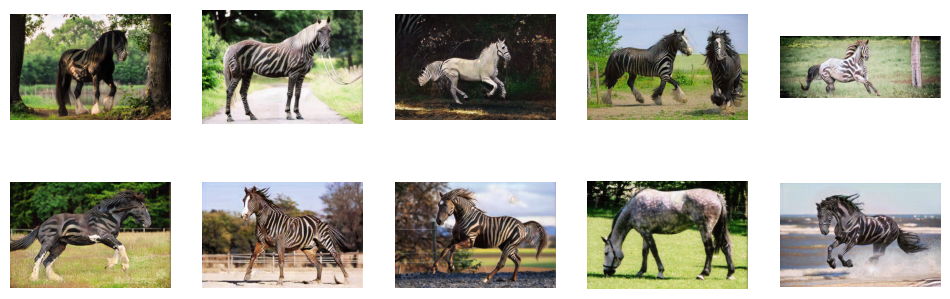

In [2]:
# Aufgabe 2
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)
netG = ResNetGenerator()

model_path = 'horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)
netG.eval()


img1 = Image.open("Horse1.jpeg")
img2 = Image.open("Horse2.jpg")
img3 = Image.open("Horse3.jpeg")
img4 = Image.open("Horse4.jpg")
img5 = Image.open("Horse5.jpg")
img6 = Image.open("Horse6.jpg")
img7 = Image.open("Horse7.jpg")
img8 = Image.open("Horse8.jpg")
img9 = Image.open("Horse9.jpeg")
img10 = Image.open("Horse10.jpg")

image_datas = [img1,img2,img3,img4,img5,img6,img7,img9,img8, img10]

preprocess = transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
f, axarr = plt.subplots(2,5,figsize=(12, 4))
u = 0
j = 0

for i in range(0,10):
    
    img_t = preprocess(image_datas[i])
    batch_t = torch.unsqueeze(img_t, 0)
    batch_out = netG(batch_t)
    out_t = (batch_out.data.squeeze() + 1.0) / 2.0
    out_img = transforms.ToPILImage()(out_t)
  
 
    axarr[u,j].imshow(out_img)
    axarr[u,j].axis('off')
    #axarr[u,j].set_title(k,fontsize=5)
    j = j+1
    if i==4:
        j = 0
        u = 1